# Image Colorizer with MSE Loss

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter

import kornia
from torchview import draw_graph

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Image Data Loader

This is responsible for loading, resizing, and applying transformations to images used to train the model. It can also load unprocessed images which is useful for comparing generated images to the color originals.

In [2]:
class image_loader(torch.utils.data.Dataset):

    def __init__(self, batch_size, directory):
        super().__init__()
        
        self.image_dir = directory
        self.batch_size = batch_size
        self.all_file_paths = [directory + file_name for file_name in os.listdir(directory)]
    
    def __len__(self):
        
        return len(self.all_file_paths)//self.batch_size

    def __getitem__(self, batch_number):
        
        image_numbers = range(batch_number * self.batch_size, (batch_number+1) * self.batch_size)

        # Batch Size x Channels x Height x Width
        batch_l_channel = torch.empty((0, 1, h_image_size, h_image_size))
        batch_ab_channels = torch.empty((0, 2, h_image_size, h_image_size))
        for image_number in image_numbers:

            image_l_channel, image_ab_channels = self.load_processed_image_channels(image_number)
            
            batch_l_channel = torch.cat((batch_l_channel, image_l_channel),0)
            batch_ab_channels = torch.cat((batch_ab_channels, image_ab_channels))

        return batch_l_channel, batch_ab_channels

    def load_processed_image_channels(self, image_number, training = True):

        image = torchvision.io.read_image(self.all_file_paths[image_number])
        
        image = torchvision.transforms.Resize(
                (h_image_size, h_image_size),
                antialias=None)(image)
        
        if training:
            image = torchvision.transforms.RandomHorizontalFlip()(image)
            image = torchvision.transforms.RandomVerticalFlip()(image)
        image = image = torch.unsqueeze(image,0)
        # Get RGB values between 0 and 1
        image = image/256
        image = kornia.color.rgb_to_lab(image)

        # L values 1 - 100 --> -1 - 1
        l_channel = torch.subtract(image[:,0,:,:],50)/50
        # AB values -128 - 127 --> -1 - 1
        ab_channels = image[:,1:,:,:]/128
        
        return torch.unsqueeze(l_channel,0), ab_channels

    def load_unprocessed_image(self, image_number):
        
        image = torchvision.io.read_image(self.all_file_paths[image_number])
        image = torchvision.transforms.Resize(
                (h_image_size, h_image_size),
                antialias=None)(image)
        
        image = image.movedim(0,-1)
        
        return image

# Downsampling Block for U-Net Encoder

This defines a convolutional block with batch normalization and residual connections for the downsampling stack of the u-net.

In [3]:
class Downsampling(nn.Module):

    def __init__(self, in_filters, out_filters):
        super().__init__()

        # Output height and width = 1/2 x input height and width
        self.conv = nn.Conv2d(in_filters, out_filters,
                              kernel_size = 5, stride = 2 ,padding=2)

        # Output height and width = 1/2 x input height and width
        self.residual = nn.Conv2d(in_filters, out_filters,
                              kernel_size = 1, stride = 2)
        
        self.norm = nn.BatchNorm2d(out_filters)
        self.dropout = nn.Dropout(0.2)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):

        block = self.conv(x)
        block = self.norm(block)
        block = self.activation(block)
        block = self.dropout(block)
        residual = self.residual(x)
        block = torch.add(block, residual)
        
        return block

# Upsampling Block for U-Net Decoder

This defines a convolutional block with batch normalization, residual connections, and skip connections from the downsampling stack for the upsampling stack of the u-net.

In [4]:
class Upsampling(nn.Module):

    def __init__(self, in_filters, out_filters):
        super().__init__()

        # Output height and width = 2 x input height and width
        self.conv = nn.ConvTranspose2d(in_filters, out_filters, kernel_size = 4, stride = 2,
                                      padding=1)

        # Output height and width = 2 x input height and width
        self.residual = nn.ConvTranspose2d(in_filters, out_filters, kernel_size = 1, stride = 2,
                                     output_padding=1)
        
        self.norm = nn.BatchNorm2d(out_filters)
        self.dropout = nn.Dropout(0.2)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x, skip):

        block = self.conv(x)

        block = self.norm(block)
        block = self.activation(block)
        block = self.dropout(block)
        residual = self.residual(x)
        block = torch.add(block, residual)
        # Concatenate skip connection on channel axis
        block = torch.cat((block, skip),1)
        
        return block

# U-Net Model Definition

Defines the u-net model used for the generator. It is composed of a downsampling stack and an upsampling stack with skip connections between layers in each stack. The number of layers in the downsampling stack and upsamplings stack are automatically determined by the image size hyperparameter and the number of filters in each layer is automatically determined by the max filters hyperparameter and image size hyperparameter. Also contains a colorize method to handle recombining the gray channel with the generated color channels during inference.

In [5]:
class Generator(nn.Module):

    def __init__(self, image_size, max_filters):
        super().__init__()

        # Number of layers changes based on the shape of the input images
        # to reduce image size to 1 x 1 in the bottom layer
        self.n_layers = int(np.floor(np.log2(image_size)))
        self.max_filters = max_filters
        
        self.input = nn.Conv2d(in_channels = 1,out_channels = 16, kernel_size = 5,
                               padding= 2)
        
        self.finalconv = nn.ConvTranspose2d(in_channels = 32, out_channels=2, kernel_size=1, stride=1)

        # ==== Create Downsampling Stack ====
        
        self.downstack = []
        # Output filters is double the number of input filters unless it would exceed max filters
        # First layer always starts with 16 filters (2 **(4 + layer))
        for layer in range(self.n_layers):
            if 2 ** (4+layer) < self.max_filters:
                self.downstack.append(Downsampling(in_filters=2 ** (4+layer),
                                                   out_filters=2 ** (5+layer)))
            else:
                self.downstack.append(Downsampling(in_filters=self.max_filters,
                                                   out_filters=self.max_filters))
                
        self.downstack = nn.ModuleList(self.downstack)   

        # ==== Initial Layer for Upsampling Stack ====

        # Bottom layer of upsampling stack should have the same number of filters as the last
        # layer of the downsampling stack outputs
        # There is no skip connection before this so output filters is 1/2 the number of input
        # filters or max filters
        if 2 ** (4+self.n_layers) > self.max_filters:
            self.upstack_init = [Upsampling(in_filters = self.max_filters,
                                            out_filters = self.max_filters)]         
        else: 
            self.upstack_init = [Upsampling(in_filters = 2 ** (4+self.n_layers),
                                            out_filters = 2 ** (3+self.n_layers))]

        # ==== Create Remaining Upsampling Stack ====

        # Output filters is 1/4 the number of input filters. Half input filters come from the previous
        # layer in the upsampling stack and half come from the skip connection in the downsampling
        # stack. Final layer should have 16 output filters.
        self.upstack = []
        for layer in range(self.n_layers-1):
            if 2**(self.n_layers - layer + 3) > self.max_filters:
                self.upstack.append(Upsampling(in_filters = 2 * self.max_filters,
                                                out_filters = self.max_filters))
            else:
                self.upstack.append(Upsampling(in_filters = 2**(self.n_layers - layer + 4),
                                                out_filters = 2**(self.n_layers - layer + 2)))
                
        self.upstack = nn.ModuleList(self.upstack_init + self.upstack)

        self.apply(self.__init_weights)
        
    def __init_weights(self, module):
        
        if isinstance(module, nn.Conv2d):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.ConvTranspose2d):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, x):

        skips = []
        conv = self.input(x)
        skips.append(conv)
        # Make a list chaining all downsampling layers so skip connections can be made to them
        for x in self.downstack:
            skipconv = x(conv)
            skips.append(skipconv)
            conv = skips[-1]
            
        for idx, layer in enumerate(self.upstack):
            # -(idx+2) because the first layer should not skip connect to the bottom layer but to 
            # the one before that and idx starts at 0
            conv = layer(conv, skips[-(idx+2)])
        
        out = self.finalconv(conv)
        out = F.tanh(out)

        return out

    def colorize(self, x):

        predictions = self.forward(x).detach()
        # L values -1 - 1 --> 1 - 100
        x_adj = torch.add(x*50,50).to(torch.long)
        # AB values -1 - 1 --> -128 - 127
        predictions = (predictions * 128).to(torch.long)
        image = torch.cat((x_adj, predictions),1)    
        image = kornia.color.lab_to_rgb(torch.squeeze(image,0))
        image = image.movedim(0,-1)
        
        return image

# Hyperparameters

In [6]:
h_epochs = 50
h_saves = 10                  # Number of examples to save from training epochs
h_image_size = 64             # Power of 2 >= 16
h_max_allowable_filters = 512  # Power of 2 >= 16
h_batch_size = 500            # Evenly divides length of dataset
h_train_dir = 'Train/'
h_test_dir = 'Test/'

# Initialize Model 

This creates the generator, generator optimizer and data loaders for the train and test datasets. It also creates lists and a tensorboard writer to save training results to.

In [7]:
generator = Generator(h_image_size, h_max_allowable_filters).to(device)
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)

train_data_loader = image_loader(h_batch_size, h_train_dir)
test_data_loader = image_loader(1, h_test_dir)

tbwriter = SummaryWriter(log_dir='runs/mse')
saved_epochs = []
losses = []

# Training Model

This cell trains the generator for the specified number of epochs. It also saves the training results to the lists created earlier. An example image is saved when the number of saves (h_saves) evenly divides the epoch number.

In [8]:
#with torch.autograd.profiler.profile() as prof:
generator.train();
for epoch in tqdm(range(h_epochs)):

    # Iterate through the dataset once per epoch
    data_iterator = iter(train_data_loader)

    for batch in range(len(train_data_loader)):

        # Make predictions
        x, y = next(data_iterator)
        x, y = x.to(device), y.to(device)
        model_out = generator.forward(x)

        # Calculate and save loss
        loss = F.mse_loss(model_out,y)
        step = (epoch * len(train_data_loader)) + batch
        tbwriter.add_scalar("Loss/train", loss, step)
        losses.append(loss.to('cpu').detach().numpy())

        # Train model
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save an image when number of saves evenly divides epoch number
    if not ((epoch+1) % (h_epochs//h_saves)):
        
        generator.eval()

        x, y = train_data_loader.load_processed_image_channels(42, training = False)
        x, y = x.to(device), y.to(device)
        predictions = generator.colorize(x)
        saved_epochs.append(predictions.to('cpu').numpy())
        
        generator.train()
    
tbwriter.flush()   
generator.eval();      
#print(prof.key_averages().table(sort_by="self_cpu_time_total"))
torch.save(generator, 'models/mse_gen.pt')

100%|███████████████████████████████████████████████████████| 50/50 [12:32<00:00, 15.05s/it]


# Loss

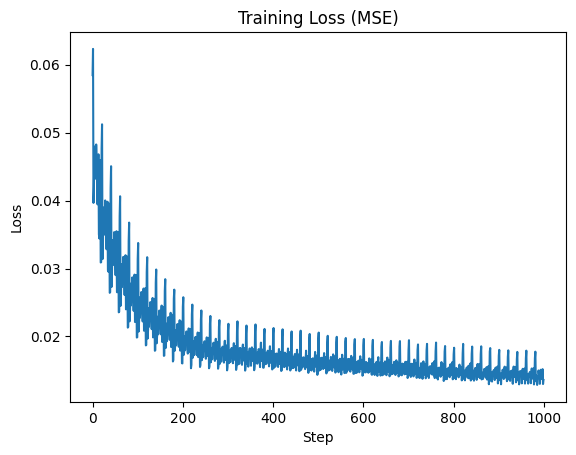

In [9]:
loss_fig, loss_ax = plt.subplots()
loss_ax.plot(range(len(losses)),losses)
loss_ax.set_title('Training Loss (MSE)');
loss_ax.set_xlabel('Step');
loss_ax.set_ylabel('Loss');

# Epoch Examples

This shows how the model improves at colorizing images as training progresses.

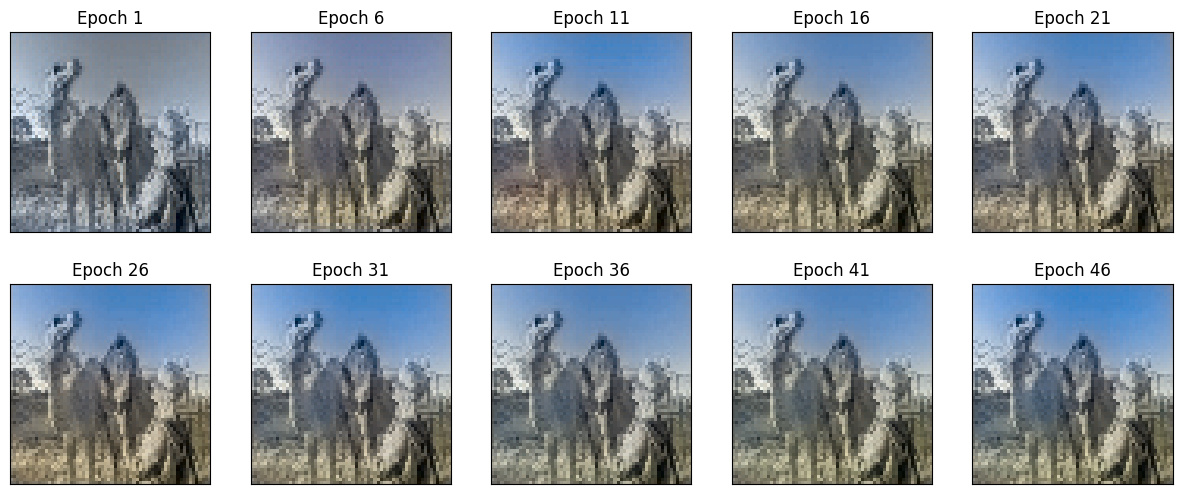

In [10]:
rows = (np.ceil(len(saved_epochs)/5)).astype(int)
skips = h_epochs // h_saves

if rows == 1:
    fig, ax = plt.subplots(1,5,figsize=(15,3))
    for index, axis in enumerate(ax):
        try:
            axis.imshow(saved_epochs[index])
            axis.set_xticks([])
            axis.set_yticks([])
            axis.set_title(f'Epoch {1+(index * h_epochs // h_saves)}')
        except:
            pass
else:
    fig, ax = plt.subplots(rows,5,figsize=(15,3*rows))
    for row_no, row in enumerate(ax):
        for index, axis in enumerate(row):
            try:
                axis.imshow(saved_epochs[index + 5* row_no])
                axis.set_xticks([])
                axis.set_yticks([])
                axis.set_title(f'Epoch {1 + (5 * row_no * skips) + (index * skips)}')
            except:
                pass

# Display Example Images

In [11]:
def show_example_images(loader, number, offset):

    fig, ax = plt.subplots(number, 3, figsize = (12,4*number))

    for image_number in range(offset, offset+number):
    
        ax[image_number][0].imshow(loader.load_unprocessed_image(
        image_number)[:,:,0], cmap='gray')
        
        ax[image_number][2].imshow(loader.load_unprocessed_image(image_number))
    
        x, y = loader.load_processed_image_channels(image_number, training = False)
        x, y = x.to(device), y.to(device)
        
        predictions = generator.colorize(x)
        ax[image_number][1].imshow(predictions.to('cpu').detach().numpy())
    
        ax[image_number][0].set_title('Grayscale Input')
        ax[image_number][1].set_title('Colorized Image')
        ax[image_number][2].set_title('Ground Truth')
        for axis in ax[image_number]:
            axis.set_xticks([])
            axis.set_yticks([])
            
    return fig

# Training Image Results

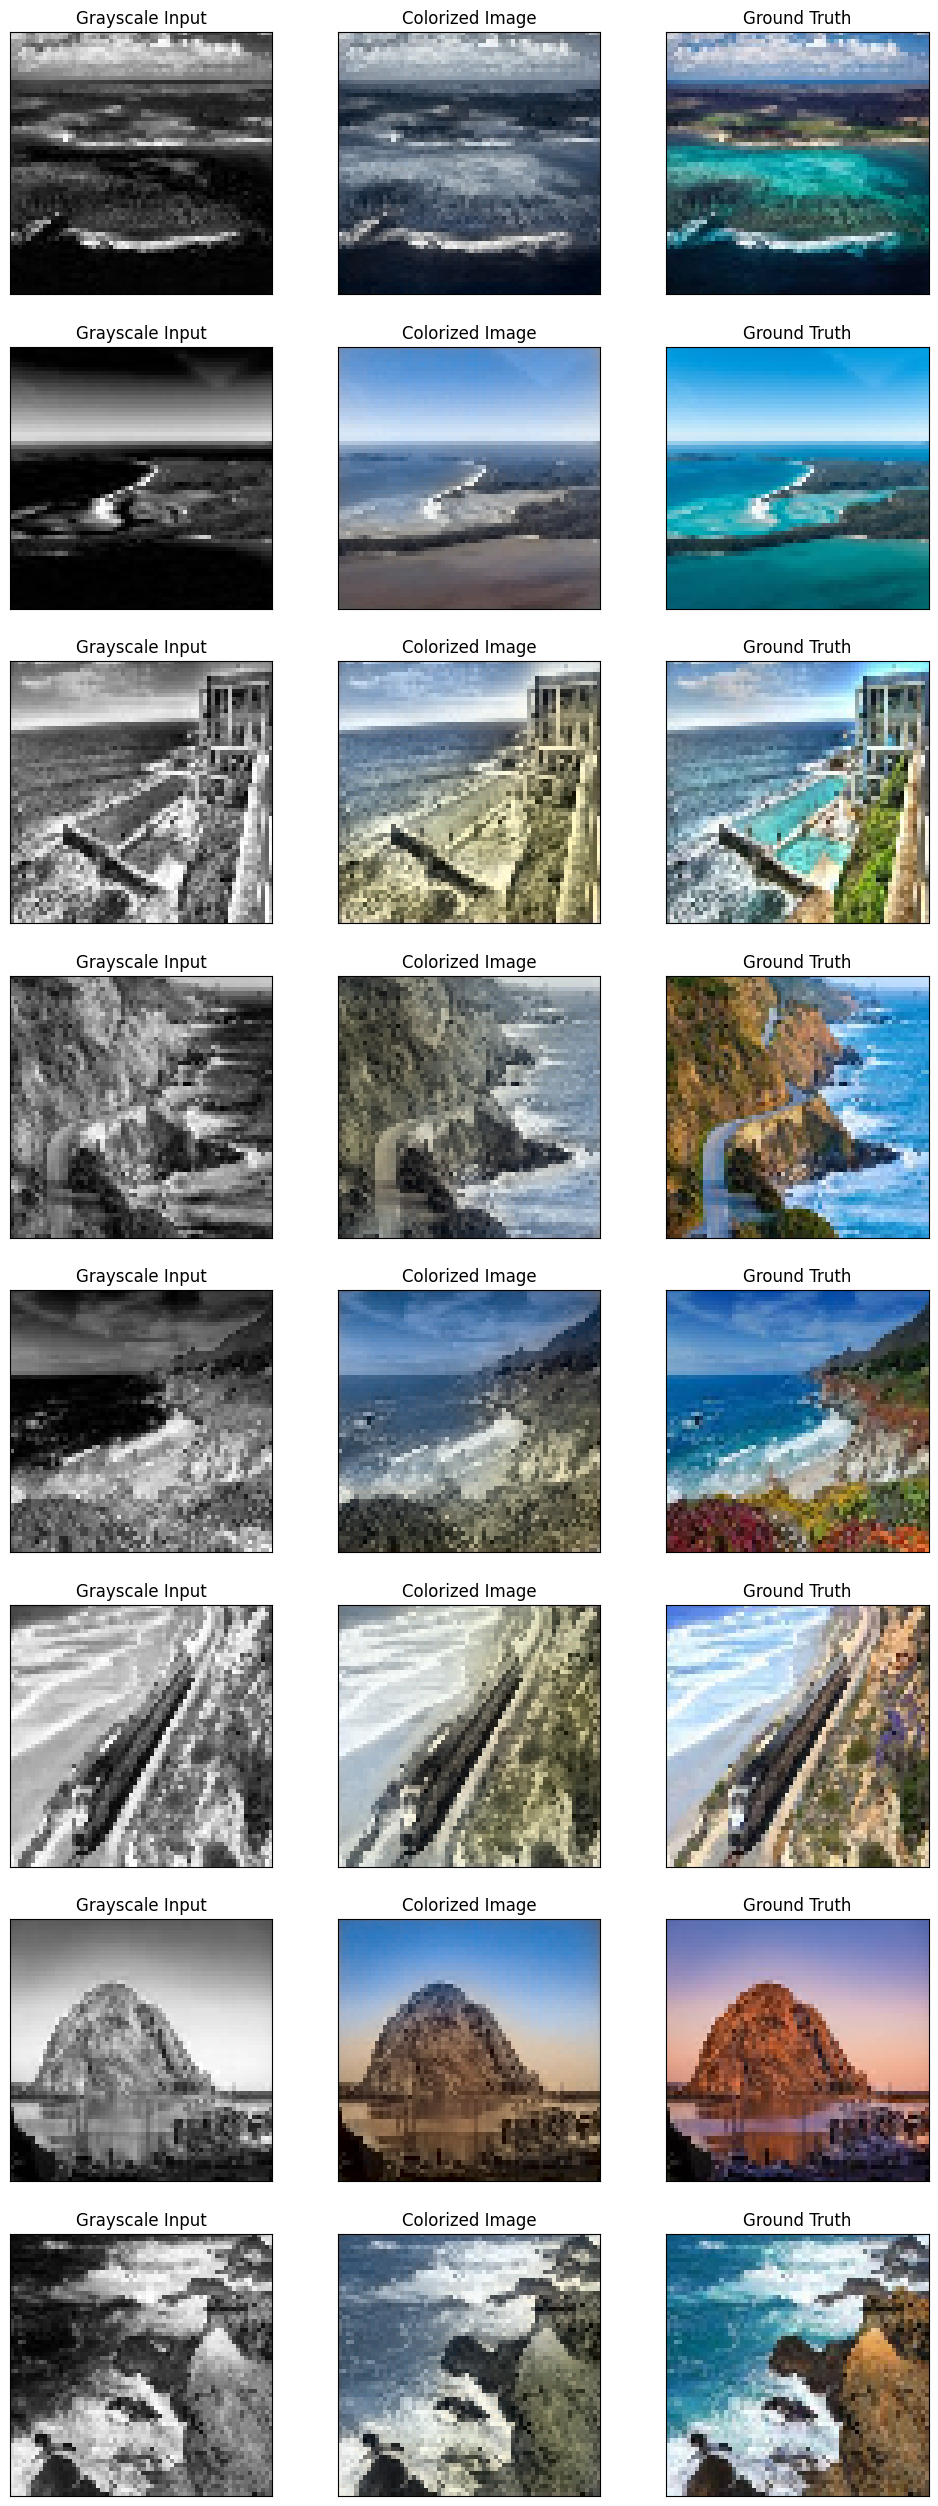

In [12]:
show_example_images(train_data_loader, number = 8, offset = 0);

# Test Image Results

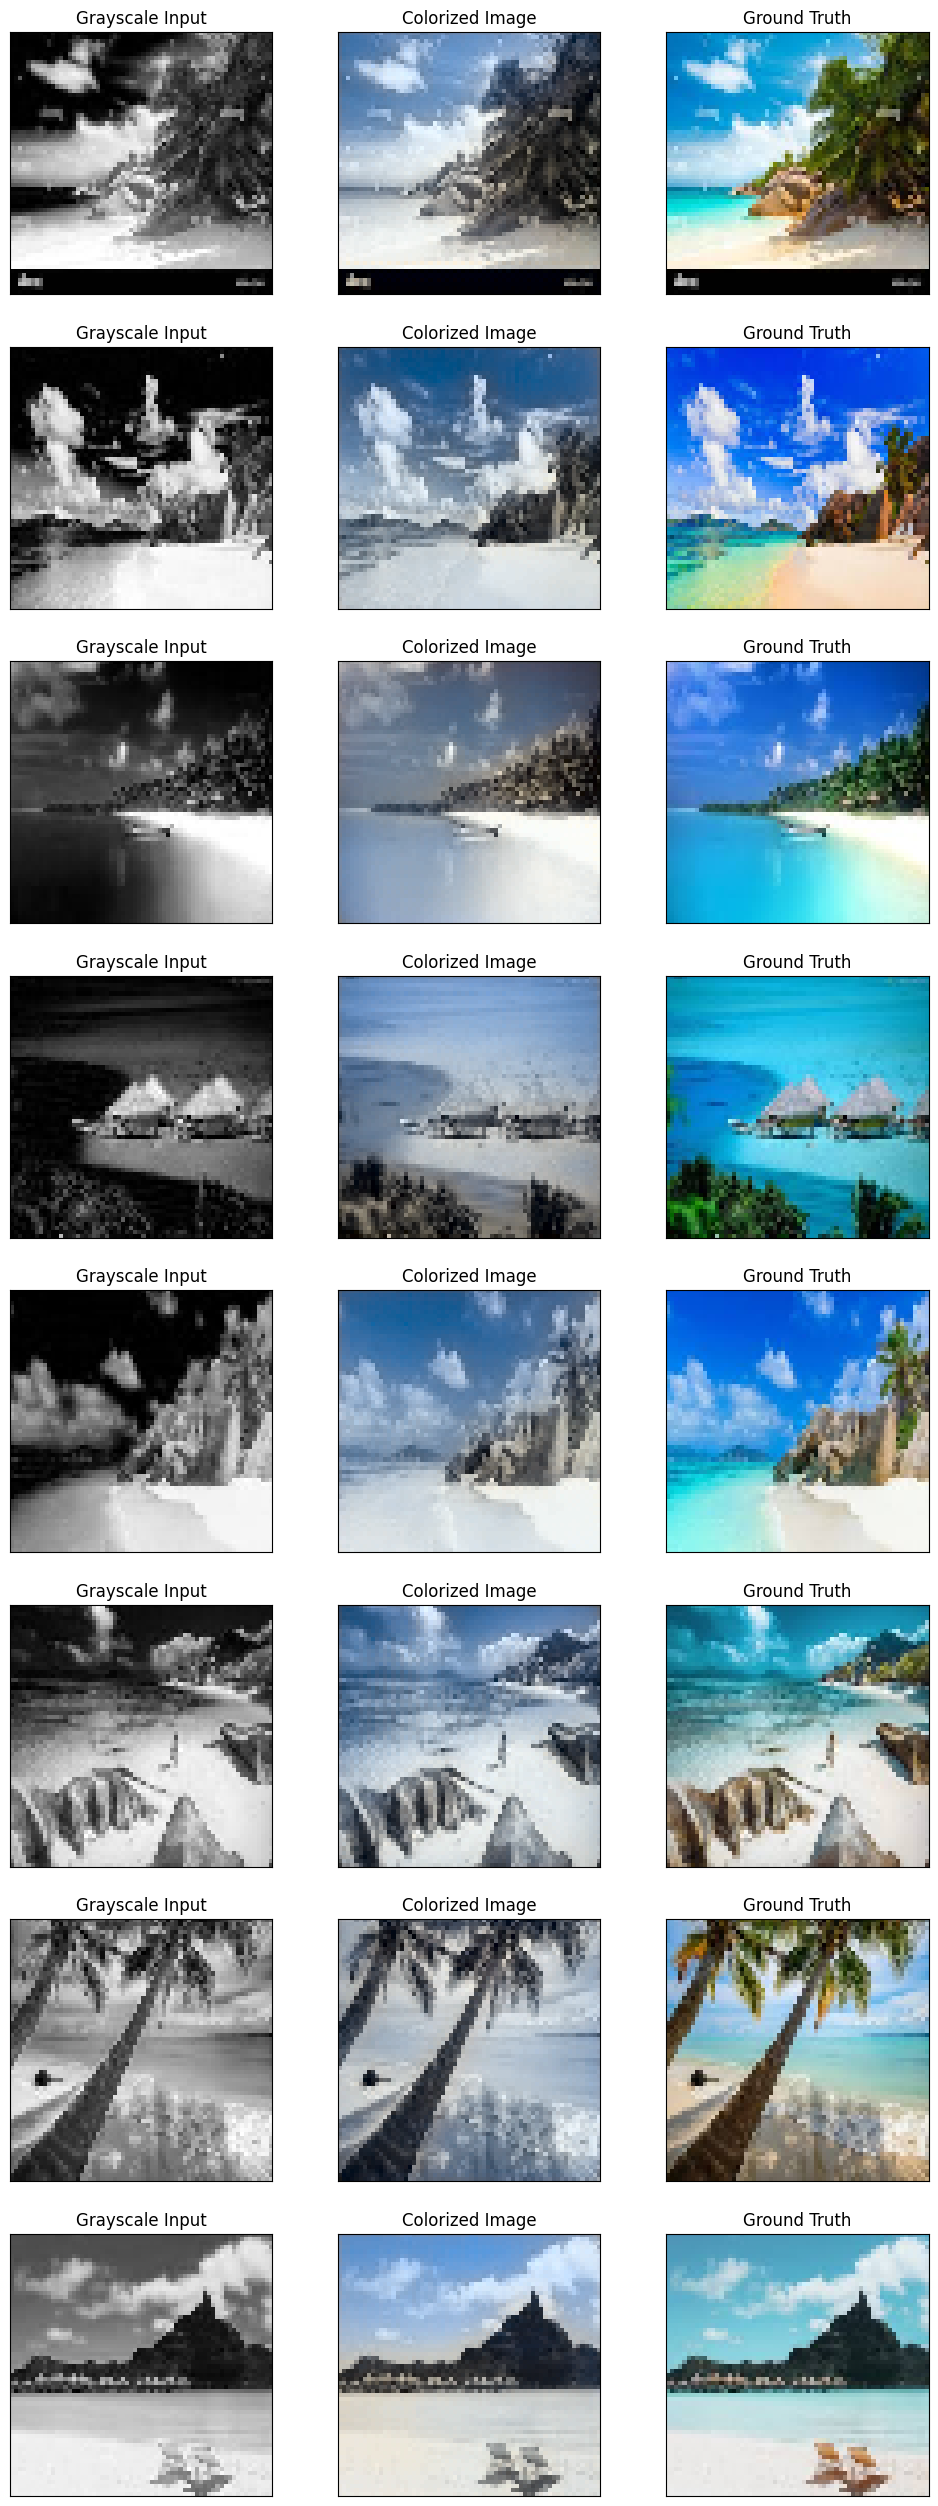

In [13]:
show_example_images(test_data_loader, number = 8, offset = 0);

# Graph of Model Architecture

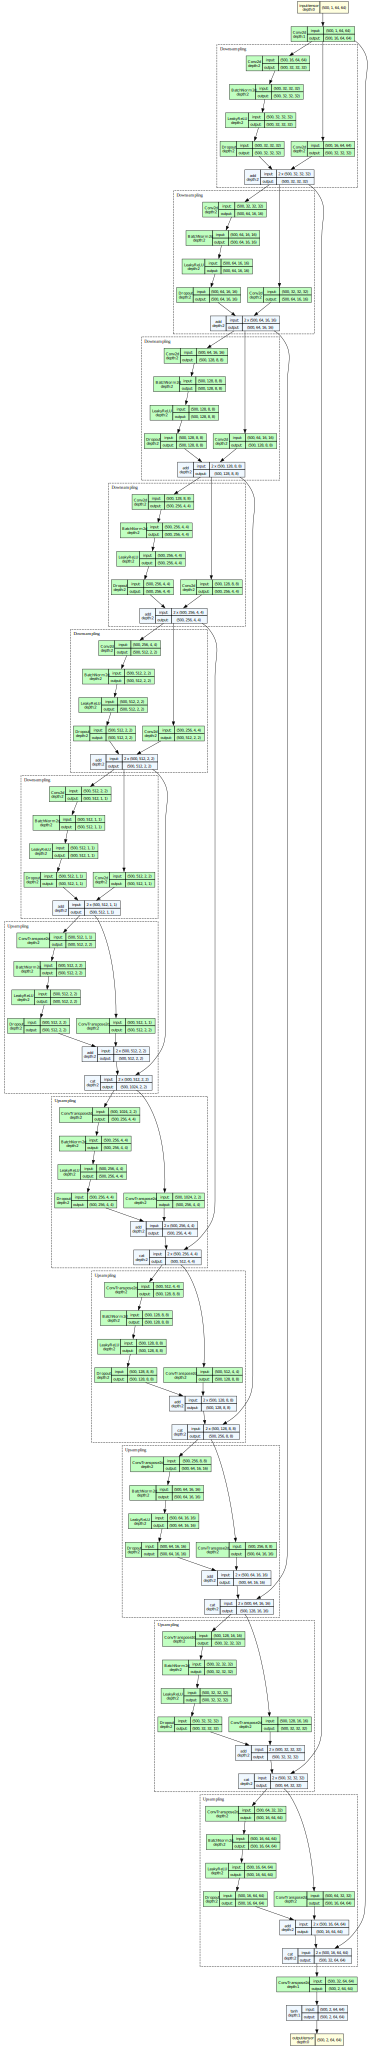

In [14]:
model_graph = draw_graph(generator, input_size=(h_batch_size, 1 ,h_image_size, h_image_size),
                         device=device, expand_nested=True)
model_graph.visual_graph